# Classification. Linear models and KNN

In [43]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [46]:
data = pd.read_csv('/content/drive/MyDrive/Courses/RS School ML/ml-intro-2021/5_classification_linear_knn/train.csv').set_index('PassengerId')

In [47]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [48]:
males, females = data['Sex'].value_counts()['male'], data['Sex'].value_counts()['female']
males, females

(577, 314)

In [49]:
surv_males, surv_females = data[data['Survived'] == 1]['Sex'].value_counts()['male'], data[data['Survived'] == 1]['Sex'].value_counts()['female']
surv_males, surv_females

(109, 233)

In [50]:
male_survived_pct, female_survived_pct = surv_males / males, surv_females / females
male_survived_pct, female_survived_pct

(0.18890814558058924, 0.7420382165605095)

< your thoughts > Женщин выжило больше

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

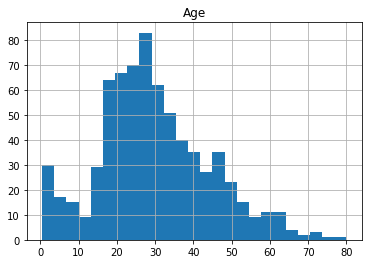

In [51]:
data.hist(column='Age', bins=25)
plt.show()

In [52]:
print("Avg age of survived: {}, median age of survived: {}".format(data[data['Survived'] == 1]['Age'].mean(), data[data['Survived'] == 1]['Age'].median()))
print("Avg age of deceased: {}, median age of deceased: {}".format(data[data['Survived'] == 0]['Age'].mean(), data[data['Survived'] == 0]['Age'].median()))

Avg age of survived: 28.343689655172415, median age of survived: 28.0
Avg age of deceased: 30.62617924528302, median age of deceased: 28.0


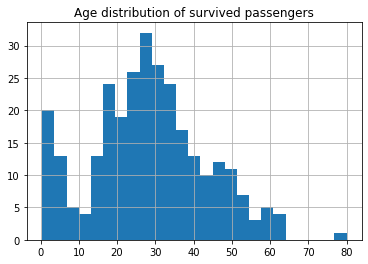

In [53]:
data[data['Survived'] == 1].hist(column='Age', bins=25)
plt.title('Age distribution of survived passengers')
plt.show()

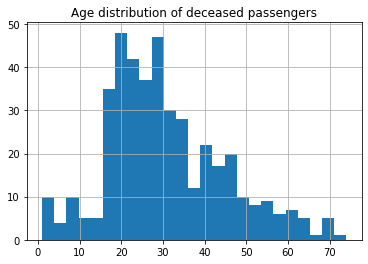

In [54]:
data[data['Survived'] == 0].hist(column='Age', bins=25)
plt.title('Age distribution of deceased passengers')
plt.show()

< your thoughts > Среди выживших больше детей, среди пострадавших больше пожилых

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [55]:
data.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [56]:
pclass1survived_pct = data[data['Pclass'] == 1]['Survived'].value_counts()[1] / data[data['Pclass'] == 1]['Survived'].value_counts().sum()
pclass2survived_pct = data[data['Pclass'] == 2]['Survived'].value_counts()[1] / data[data['Pclass'] == 2]['Survived'].value_counts().sum()
pclass3survived_pct = data[data['Pclass'] == 3]['Survived'].value_counts()[1] / data[data['Pclass'] == 3]['Survived'].value_counts().sum()
pclass1survived_pct, pclass2survived_pct, pclass3survived_pct

(0.6296296296296297, 0.47282608695652173, 0.24236252545824846)

Среди 1 класса больший процент выживших

In [57]:
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [58]:
emb_S_survived_pct = data[data['Embarked'] == 'S']['Survived'].value_counts()[1] / data[data['Embarked'] == 'S']['Survived'].value_counts().sum()
emb_C_survived_pct = data[data['Embarked'] == 'C']['Survived'].value_counts()[1] / data[data['Embarked'] == 'C']['Survived'].value_counts().sum()
emb_Q_survived_pct = data[data['Embarked'] == 'Q']['Survived'].value_counts()[1] / data[data['Embarked'] == 'Q']['Survived'].value_counts().sum()
emb_S_survived_pct, emb_C_survived_pct, emb_Q_survived_pct

(0.33695652173913043, 0.5535714285714286, 0.38961038961038963)

Среди EMbarked = C больший процент выживших

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [59]:
data.isnull().mean().sort_values(ascending = False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
Fare        0.000000
Ticket      0.000000
Parch       0.000000
SibSp       0.000000
Sex         0.000000
Name        0.000000
Pclass      0.000000
Survived    0.000000
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Объекты с Embarked = Nan можно выкинуть(их всего 0.2 %).
Возраст можно предсказать, используя остальные фичи.
Фича Cabin много у кого пропущена + думаю она не особо важна, а возможно даже кореллирует с фичей class, ее можно выкинуть.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

И KNN и LOGREG ОБУЧЕНЫ ПОСЛЕ КОПАНИЯ В ФИЧАХ В КОНЦЕ

In [60]:
test_data = pd.read_csv('/content/drive/MyDrive/Courses/RS School ML/ml-intro-2021/5_classification_linear_knn/test.csv')
train_data = pd.read_csv('/content/drive/MyDrive/Courses/RS School ML/ml-intro-2021/5_classification_linear_knn/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [61]:
y = data['Survived']

In [62]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [63]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [64]:
test_data = pd.read_csv('/content/drive/MyDrive/Courses/RS School ML/ml-intro-2021/5_classification_linear_knn/test.csv')
train_data = pd.read_csv('/content/drive/MyDrive/Courses/RS School ML/ml-intro-2021/5_classification_linear_knn/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Выкинем кабину

In [65]:
train_data.drop(['Cabin'], axis = 'columns', inplace = True)
test_data.drop(['Cabin'], axis = 'columns', inplace = True)

In [66]:
train_data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

S значительно больше, им и заполним

In [67]:
train_data.Embarked.fillna('S', inplace = True)

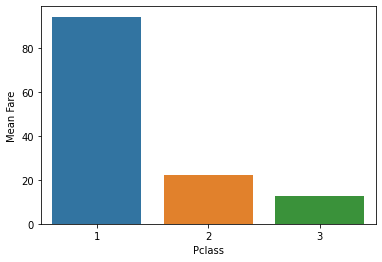

In [68]:
fares = test_data.groupby("Pclass")['Fare'].mean()
sns.barplot(x = fares.index, y = fares)
plt.ylabel("Mean Fare")
plt.show()


In [69]:
fares

Pclass
1    94.280297
2    22.202104
3    12.459678
Name: Fare, dtype: float64

Заполним Fare средним Fare в зависимости от класса

In [70]:
for pclass in fares.index:
    test_data["Fare"][(test_data.Fare.isna()) & (test_data.Pclass == pclass)] = fares[pclass]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
for obj in [train_data, test_data]:
    obj['Title'] = obj['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)

In [72]:
obj.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,Mrs


In [73]:
mean_age_from_name = pd.concat([train_data, test_data]).groupby("Title").Age.mean()

Заполним пропущенные возрасты средним из префикса с имени(Miss, mrs, mstr etc)

In [74]:
for obj in [train_data, test_data]:
    for substr in mean_age_from_name.index:
        obj["Age"][(obj['Age'].isna()) & (obj['Title'] == substr)] = mean_age_from_name[substr]  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
train_data.isnull().mean().sort_values(ascending = False)

Title          0.0
Embarked       0.0
Fare           0.0
Ticket         0.0
Parch          0.0
SibSp          0.0
Age            0.0
Sex            0.0
Name           0.0
Pclass         0.0
Survived       0.0
PassengerId    0.0
dtype: float64

In [76]:
test_data.isnull().mean().sort_values(ascending = False)

Title          0.0
Embarked       0.0
Fare           0.0
Ticket         0.0
Parch          0.0
SibSp          0.0
Age            0.0
Sex            0.0
Name           0.0
Pclass         0.0
PassengerId    0.0
dtype: float64

In [77]:
for obj in [train_data, test_data]:
    obj['Title'] = obj['Title'].replace(['Mlle', 'Ms'], 'Miss')
    obj['Title'] = obj['Title'].replace(['Mme', "Countess", "Lady", "Dona"], 'Mrs')    
    obj['Title'] = obj['Title'].replace(['Capt', "Col", "Don", "Jonkheer", "Major", "Rev", "Sir"], "Other")
    obj.loc[((obj.Title == "Dr") & (obj.Sex == "female")), 'Title'] = "Mrs"
    obj.loc[((obj.Title == "Dr") & (obj.Sex == "male")), 'Title'] = "Mr"

In [78]:
for obj in [train_data, test_data]:
    obj['Female_Children_Classes_12'] = 0
    obj.loc[((obj.Sex == "female") | (obj.Title == "Master")) & (obj.Pclass<=2), 'Female_Children_Classes_12'] = 1

In [79]:
obj

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Female_Children_Classes_12
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,Q,Mr,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,S,Mrs,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,Q,Mr,0
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,S,Mr,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,S,Mrs,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,32.252151,0,0,A.5. 3236,8.0500,S,Mr,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C,Mrs,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,S,Mr,0
416,1308,3,"Ware, Mr. Frederick",male,32.252151,0,0,359309,8.0500,S,Mr,0


In [81]:
all_ages = list(pd.concat([train_data["Age"],test_data["Age"]]).quantile([0.0, .2, .4, .6, .8, 1]))

train_data["Age_Range"] = pd.cut(train_data["Age"], bins = all_ages, labels = [1,2,3,4,5], include_lowest = True)
test_data["Age_Range"] = pd.cut(test_data["Age"],bins = all_ages, labels = [1,2,3,4,5], include_lowest = True)

In [83]:
Child_limit_age = 16
for obj in [train_data, test_data]:
    obj['Child'] = obj.Age.map(lambda x: 1 if x <= Child_limit_age else 0)

In [84]:
for obj in [train_data, test_data]:
    obj["Num_Family_Members"] = 1 + obj.SibSp + obj.Parch
    obj['Alone'] = obj["Num_Family_Members"].\
    map(lambda s: 1 if s == 1 else 0)

In [85]:
all_tickets = pd.concat([train_data, test_data]).groupby('Ticket').PassengerId.count()

for obj in [train_data, test_data]:
    obj["Num_Group_Members"] = 1
    for ticket in list(all_tickets.index):
        num_group_members = all_tickets[ticket]
        obj.loc[obj.Ticket == ticket, 'Num_Group_Members'] = num_group_members
        obj.loc[obj.Ticket == ticket, 'Group_Id'] = ticket
        if num_group_members > 1:
            obj.loc[obj.Ticket == ticket, 'Alone'] = 0

In [86]:
train_tickets_survivors = train_data.groupby('Group_Id').Survived.sum()
for obj in [train_data, test_data]:
    obj["Survival_in_group"] = 0       
    for group in list(train_tickets_survivors.index):
        obj.loc[(obj.Group_Id == group), 'Survival_in_group'] = train_tickets_survivors[group]

In [87]:
for obj in [train_data, test_data]:
    obj['Master_And_Survival_Group'] = 0
    obj.loc[((obj.Title == "Master") & (obj.Survival_in_group > 0)), 'Master_And_Survival_Group'] = 1

In [88]:
women_in_group = pd.concat([train_data[(train_data.Sex == "female")], test_data[(test_data.Sex == "female")]]).groupby('Group_Id').PassengerId.count()

for obj in [train_data, test_data]:
    obj["Women_in_group"] = 0
    for group in list(women_in_group.index):
        obj.loc[(obj.Group_Id == group), 'Women_in_group'] = women_in_group[group]

In [89]:
Parent_Age = 25
men_in_group = pd.concat([train_data[(train_data.Title=="Mr") & (train_data.Parch>0) & (train_data.Age>=Parent_Age)], test_data[(test_data.Title=="Mr") & (test_data.Parch>0) & \
(test_data.Age>=Parent_Age)]]).groupby('Group_Id').PassengerId.count()

for obj in [train_data, test_data]:
    obj["Men_in_group"] = 0
    for group in list(men_in_group.index):
        obj.loc[(obj.Group_Id == group),'Men_in_group'] = men_in_group[group]

In [ ]:
for dataset in [train_data, test_data]:
    dataset["Alone_Mr"] = 0
    dataset.loc[(dataset.Title == "Mr")&(dataset.Alone == 1),'Alone_Mr'] = 1

In [90]:
women_in_survival_group = pd.concat([train_data[(train_data.Sex == "female") & (train_data.Survival_in_group >= 1)], test_data[(test_data.Sex == "female") & \
                                     (test_data.Survival_in_group >= 1)]]).groupby('Group_Id').PassengerId.count()

for obj in [train_data, test_data]:
    obj["Women_in_survival_group"] = 0
    for group in list(women_in_survival_group.index):
        obj.loc[(obj.Group_Id == group),'Women_in_survival_group'] = women_in_survival_group[group]

In [ ]:
master_in_group = pd.concat([train_data[train_data.Title=="Master"],\
                             test_data[test_data.Title=="Master"]]).\
groupby('Group_Id').PassengerId.count()

for dataset in [train_data, test_data]:
    dataset["Master_in_group"] = 0
    for group in list(master_in_group.index):
        dataset.loc[(dataset.Group_Id == group),'Master_in_group'] = master_in_group[group]

In [91]:
all_fares = list(pd.concat([train_data["Fare"],test_data["Fare"]]).quantile([0.0, .2, .4, .6, .8,1]))
train_data["Fare_Range"] = pd.cut(train_data["Fare"], bins=all_fares, labels=[1, 2, 3, 4, 5], include_lowest = True)
test_data["Fare_Range"] = pd.cut(test_data["Fare"],bins = all_fares, labels=[1, 2, 3, 4, 5], include_lowest = True)

OHE

In [92]:
for feature in ["Title","Sex","Pclass","Embarked"]:
    train_data = pd.concat([train_data, pd.get_dummies(train_data[feature], prefix=feature)], axis=1)
    test_data = pd.concat([test_data, pd.get_dummies(test_data[feature], prefix=feature)], axis=1)

In [93]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Female_Children_Classes_12,Age_Range,Child,Num_Family_Members,Alone,Num_Group_Members,Group_Id,Survival_in_group,Master_And_Survival_Group,Women_in_group,Men_in_group,Women_in_survival_group,Fare_Range,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,0,2,0,2,0,1,A/5 21171,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,4,0,2,0,2,PC 17599,1,0,1,0,1,5,0,0,0,1,0,1,0,1,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,2,0,1,1,1,STON/O2. 3101282,1,0,1,0,1,2,0,1,0,0,0,1,0,0,0,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,1,4,0,2,0,2,113803,1,0,1,0,1,5,0,0,0,1,0,1,0,1,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,0,4,0,1,1,1,373450,0,0,0,0,0,2,0,0,1,0,0,0,1,0,0,1,0,0,1


In [94]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Female_Children_Classes_12,Age_Range,Child,Num_Family_Members,Alone,Num_Group_Members,Group_Id,Survival_in_group,Master_And_Survival_Group,Women_in_group,Men_in_group,Women_in_survival_group,Fare_Range,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Mr,0,4,0,1,1,1,330911,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Mrs,0,5,0,2,0,1,363272,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Mr,0,5,0,1,1,1,240276,0,0,0,0,0,2,0,0,1,0,0,0,1,0,1,0,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Mr,0,3,0,1,1,1,315154,0,0,0,0,0,2,0,0,1,0,0,0,1,0,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,Mrs,0,2,0,3,0,2,3101298,1,0,2,0,2,3,0,0,0,1,0,1,0,0,0,1,0,0,1


In [95]:
y_train = train_data['Survived']

train_data.drop(["PassengerId", "Survived", "Name", "Sex", "Age", "Ticket", "Fare", "Pclass", "Embarked", "Title", "Group_Id"], axis = 1, inplace=True)

X_train = train_data.values

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [96]:
random_state = 1

In [103]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [109]:
param_grid = {"n_neighbors":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], "weights" : ["uniform", "distance"], "p":[1,2]}

kfold = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = random_state)

model = KNeighborsClassifier()

grid_search = GridSearchCV(model, param_grid = param_grid, scoring = "accuracy", cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

In [110]:
best_acc_score = grid_result.best_score_
best_acc_score

0.9420249827380577

In [111]:
best_params = grid_result.best_params_
best_params

{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [112]:
best_model = grid_result.best_estimator_
best_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=1,
                     weights='distance')

In [113]:
best_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=1,
                     weights='distance')

In [114]:
test_PassengerId = test_data.PassengerId

In [115]:
test_data.drop(["PassengerId", "Name", "Sex", "Age", "Ticket", "Fare", "Pclass", "Embarked", "Title", "Group_Id"], axis = 1, inplace = True)

In [116]:
X_test = test_data.values

In [117]:
y_pred = best_model.predict(X_test)

In [119]:
df_output = pd.DataFrame({'PassengerId': test_PassengerId, 'Survived': y_pred.astype(int)})


In [120]:
df_output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [121]:
df_output.to_csv("titanic_knn_11.csv", index = False)

In [123]:
!cp titanic_knn_11.csv "/content/drive/MyDrive/Courses/RS School ML/ml-intro-2021/5_classification_linear_knn"

KNN scor на kaggle 0.79904

In [124]:
random_state = 1

In [125]:
from sklearn.linear_model import LogisticRegression


In [133]:
param_grid = {"C":np.logspace(-3,3,7), "penalty":["l2"], "max_iter":[1000]}

kfold = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = random_state)

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid = param_grid, scoring = "accuracy", cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

In [134]:
best_acc_score = grid_result.best_score_
best_acc_score

0.978672608959471

In [135]:
best_model = grid_result.best_estimator_
best_model

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [136]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
df_output = pd.DataFrame({'PassengerId': test_PassengerId, 'Survived': y_pred.astype(int)})
df_output.to_csv("titanic_logreg_02.csv", index = False)
!cp titanic_knn_11.csv "/content/drive/MyDrive/Courses/RS School ML/ml-intro-2021/5_classification_linear_knn"

Logreg походу не очень, ну или надо параметров в gridsearch больше перебрать

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [ ]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

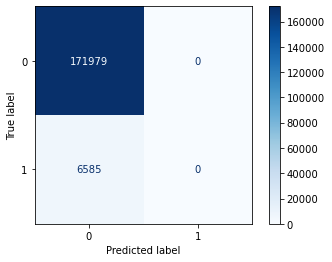

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

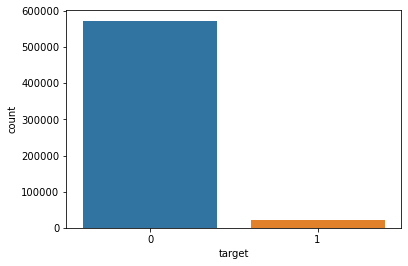

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code